In [1]:
!unzip '/content/soil-classification (1).zip'

Archive:  /content/soil-classification (1).zip
  inflating: soil_classification-2025/sample_submission.csv  
  inflating: soil_classification-2025/test/img_000f12db.jpg  
  inflating: soil_classification-2025/test/img_00a44450.jpg  
  inflating: soil_classification-2025/test/img_00af6b3b.jpg  
  inflating: soil_classification-2025/test/img_01a3f913.jpg  
  inflating: soil_classification-2025/test/img_01e540fc.jpg  
  inflating: soil_classification-2025/test/img_01f10d6d.jpg  
  inflating: soil_classification-2025/test/img_0218aefa.jpg  
  inflating: soil_classification-2025/test/img_0225b7de.jpg  
  inflating: soil_classification-2025/test/img_02c09374.jpg  
  inflating: soil_classification-2025/test/img_03137c54.jpg  
  inflating: soil_classification-2025/test/img_036e203a.jpg  
  inflating: soil_classification-2025/test/img_0387435e.jpg  
  inflating: soil_classification-2025/test/img_04309e41.jpeg  
  inflating: soil_classification-2025/test/img_04692c6c.jpg  
  inflating: soil_clas

In [44]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import resnet50, ResNet50_Weights

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report

In [45]:
# Paths
base_path = "/content/soil_classification-2025"
train_img_dir = os.path.join(base_path, "train")
test_img_dir = os.path.join(base_path, "test")

train_csv_path = os.path.join(base_path, "train_labels.csv")
test_ids_path = os.path.join(base_path, "test_ids.csv")

In [46]:
# Load and clean train CSV
train_df = pd.read_csv(train_csv_path)
train_df = train_df.rename(columns={'image_id': 'image', 'soil_type': 'label'})
train_df['img_path'] = train_df['image'].apply(lambda x: os.path.join(train_img_dir, x))
train_df = train_df[train_df['img_path'].apply(os.path.exists)].reset_index(drop=True)
train_df.drop(columns=['img_path'], inplace=True)

In [47]:
# Load internal test image list
test_ids = pd.read_csv(test_ids_path)
test_ids = test_ids.rename(columns={'image_id': 'image'})

In [48]:
# Encode labels
label_encoder = LabelEncoder()
train_df['label_enc'] = label_encoder.fit_transform(train_df['label'])

In [49]:
# Stratified split
train_split, val_split = train_test_split(
    train_df,
    test_size=0.2,
    stratify=train_df['label_enc'],
    random_state=42
)

In [50]:
# Transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [51]:
# Dataset
class SoilDataset(Dataset):
    def __init__(self, df, img_dir, transform=None, is_test=False):
        self.df = df.reset_index(drop=True).copy()
        self.img_dir = img_dir
        self.transform = transform
        self.is_test = is_test

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = self.df.iloc[idx]['image']
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        if self.is_test:
            return image, img_name
        else:
            label = self.df.iloc[idx]['label_enc']
            return image, label

In [52]:
# Datasets
train_dataset = SoilDataset(train_split, train_img_dir, transform=transform)
val_dataset = SoilDataset(val_split, train_img_dir, transform=transform)
test_dataset = SoilDataset(test_ids, test_img_dir, transform=transform, is_test=True)

In [53]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [54]:
# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

In [55]:
# Model: ResNet50
weights = ResNet50_Weights.DEFAULT
model = resnet50(weights=weights)

In [56]:
# Modify the final layer
model.fc = nn.Linear(model.fc.in_features, len(label_encoder.classes_))

# Fine-tune layer4 and fc
for name, param in model.named_parameters():
    if "layer4" in name or "fc" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

model = model.to(device)

In [57]:
# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

In [58]:
# Training loop
for epoch in range(5):
    model.train()
    running_loss = 0
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        if (i + 1) % 50 == 0:
            print(f"Epoch [{epoch+1}/5], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    print(f"Epoch [{epoch+1}/5] Avg Loss: {running_loss / len(train_loader):.4f}")

Epoch [1/5] Avg Loss: 0.9446
Epoch [2/5] Avg Loss: 0.3492
Epoch [3/5] Avg Loss: 0.1412
Epoch [4/5] Avg Loss: 0.0692
Epoch [5/5] Avg Loss: 0.0347


In [59]:
# Validation
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

print("Validation F1 Score:", f1_score(y_true, y_pred, average='weighted'))
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))


Validation F1 Score: 0.9837028787803492
               precision    recall  f1-score   support

Alluvial soil       1.00      0.96      0.98       106
   Black Soil       0.96      1.00      0.98        46
    Clay soil       0.95      1.00      0.98        40
     Red soil       1.00      1.00      1.00        53

     accuracy                           0.98       245
    macro avg       0.98      0.99      0.98       245
 weighted avg       0.98      0.98      0.98       245



In [60]:
# Test prediction
model.eval()
test_preds = []

with torch.no_grad():
    for images, img_names in test_loader:
        images = images.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)
        test_preds.extend(zip(img_names, preds.cpu().numpy()))

submission_df = pd.DataFrame(test_preds, columns=['image_id', 'label_enc'])
submission_df['soil_type'] = label_encoder.inverse_transform(submission_df['label_enc'])
submission_df = submission_df[['image_id', 'soil_type']]
submission_df.to_csv('submission.csv', index=False)
print("Internal test predictions saved to submission.csv")
print(submission_df.head())


Internal test predictions saved to submission.csv
            image_id      soil_type
0  img_cdf80d6f.jpeg  Alluvial soil
1   img_c0142a80.jpg  Alluvial soil
2   img_91168fb0.jpg  Alluvial soil
3   img_9822190f.jpg  Alluvial soil
4  img_e5fc436c.jpeg  Alluvial soil


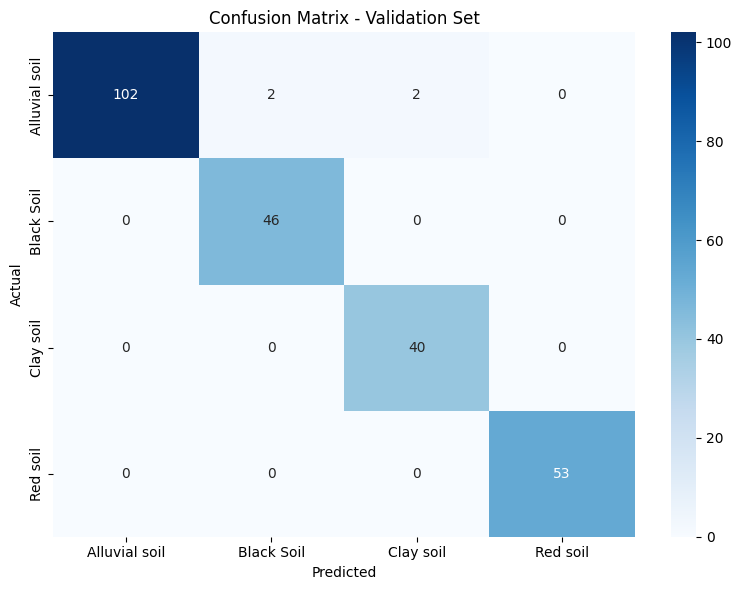

In [61]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix - Validation Set")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()
